Iteration 250: Reward = -0.9960159362549801
Iteration 500: Reward = -0.998003992015968
Iteration 750: Reward = -0.9986684420772304
Iteration 1000: Reward = -0.999000999000999
Iteration 1250: Reward = -0.9992006394884093
Iteration 1500: Reward = -0.9993337774816788
Iteration 1750: Reward = -0.9994288977727013
Iteration 250: Reward = -0.9960159362549801
Iteration 500: Reward = -0.998003992015968
Iteration 750: Reward = -0.9986684420772304
Iteration 1000: Reward = -0.999000999000999
Iteration 1250: Reward = -0.9992006394884093
Iteration 1500: Reward = -0.9993337774816788
Iteration 1750: Reward = -0.9994288977727013
Iteration 2000: Reward = -0.9995002498750625
Iteration 2250: Reward = -0.9995557529986673
Iteration 250: Reward = -0.9960159362549801
Iteration 500: Reward = -0.998003992015968
Iteration 750: Reward = -0.9986684420772304
Iteration 1000: Reward = -0.999000999000999
Iteration 1250: Reward = -0.9992006394884093
Iteration 1500: Reward = -0.9993337774816788
Iteration 1750: Reward = 

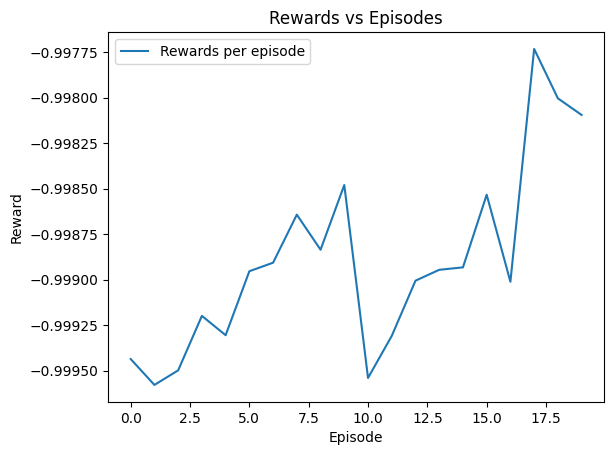

Plotting episodes vs iterations...


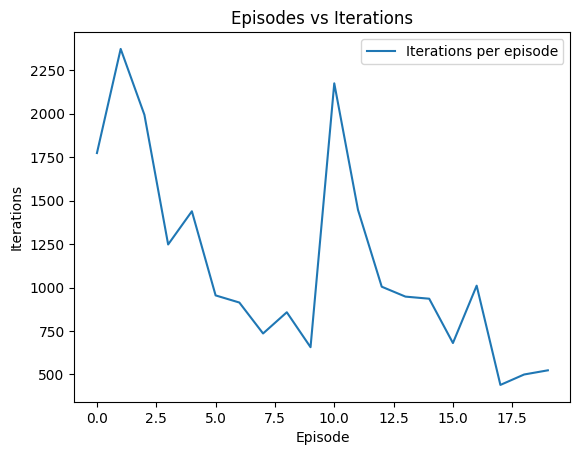

Creating video of car training to climb the hill...
Video saved to training_process.mp4


In [21]:
#!pip install numpy matplotlib opencv-python tqdm

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from math import floor
from tqdm import tqdm

# Constants for the Mountain Car environment
POSITION_MIN = -1.2
POSITION_MAX = 0.5
VELOCITY_MIN = -0.07
VELOCITY_MAX = 0.07
ACTION_REVERSE = -1
ACTION_ZERO = 0
ACTION_FORWARD = 1
ACTIONS = [ACTION_REVERSE, ACTION_ZERO, ACTION_FORWARD]

# Random action selection epsilon-greedy strategy
EPSILON = 0

class IHT:
    def __init__(self, size_val):
        self.size = size_val
        self.overfull_count = 0
        self.dictionary = {}

    def count(self):
        return len(self.dictionary)

    def full(self):
        return len(self.dictionary) >= self.size

    def get_index(self, obj, read_only=False):
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif read_only:
            return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfull_count == 0: print('IHT full, starting to allow collisions')
            self.overfull_count += 1
            return hash(obj) % self.size
        else:
            d[obj] = count
            return count

def hash_coords(coordinates, m, read_only=False):
    if isinstance(m, IHT): return m.get_index(tuple(coordinates), read_only)
    if isinstance(m, int): return hash(tuple(coordinates)) % m
    if m is None: return coordinates

def tiles(iht_or_size, num_tilings, floats, ints=None, read_only=False):
    if ints is None:
        ints = []
    qfloats = [floor(f * num_tilings) for f in floats]
    tiles = []
    for tiling in range(num_tilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append((q + b) // num_tilings)
            b += tilingX2
        coords.extend(ints)
        tiles.append(hash_coords(coords, iht_or_size, read_only))
    return tiles

class ValueFunction:
    def __init__(self, step_size, num_of_tilings=8, max_size=2048):
        self.max_size = max_size
        self.num_of_tilings = num_of_tilings
        self.step_size = step_size / num_of_tilings
        self.hash_table = IHT(max_size)
        self.weights = np.zeros(max_size)
        self.position_scale = self.num_of_tilings / (POSITION_MAX - POSITION_MIN)
        self.velocity_scale = self.num_of_tilings / (VELOCITY_MAX - VELOCITY_MIN)

    def get_active_tiles(self, position, velocity, action):
        active_tiles = tiles(self.hash_table, self.num_of_tilings,
                            [self.position_scale * position, self.velocity_scale * velocity],
                            [action])
        return active_tiles

    def value(self, position, velocity, action):
        if position == POSITION_MAX:
            return 0.0
        active_tiles = self.get_active_tiles(position, velocity, action)
        return np.sum(self.weights[active_tiles])

    def learn(self, position, velocity, action, target):
        active_tiles = self.get_active_tiles(position, velocity, action)
        estimation = np.sum(self.weights[active_tiles])
        delta = self.step_size * (target - estimation)
        for active_tile in active_tiles:
            self.weights[active_tile] += delta

    def cost_to_go(self, position, velocity):
        costs = []
        for action in ACTIONS:
            costs.append(self.value(position, velocity, action))
        return -np.max(costs)

def step(position, velocity, action):
    new_velocity = velocity + 0.001 * action - 0.0025 * np.cos(3 * position)
    new_velocity = min(max(VELOCITY_MIN, new_velocity), VELOCITY_MAX)
    new_position = position + new_velocity
    new_position = min(max(POSITION_MIN, new_position), POSITION_MAX)
    reward = -1.0
    if new_position == POSITION_MIN:
        new_velocity = 0.0
    return new_position, new_velocity, reward

def get_action(position, velocity, value_function):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    values = []
    for action in ACTIONS:
        values.append(value_function.value(position, velocity, action))
    return np.random.choice([action_ for action_, value_ in enumerate(values) if value_ == np.max(values)]) - 1

def semi_gradient_n_step_sarsa(value_function, n=1):
    current_position = np.random.uniform(-0.6, -0.4)
    current_velocity = 0.0
    current_action = get_action(current_position, current_velocity, value_function)

    positions = [current_position]
    velocities = [current_velocity]
    actions = [current_action]
    rewards = [0.0]

    time = 0
    T = float('inf')
    while True:
        time += 1
        if time < T:
            new_position, new_velocity, reward = step(current_position, current_velocity, current_action)
            new_action = get_action(new_position, new_velocity, value_function)

            positions.append(new_position)
            velocities.append(new_velocity)
            actions.append(new_action)
            rewards.append(reward)

            if new_position == POSITION_MAX:
                T = time

        update_time = time - n
        if update_time >= 0:
            returns = 0.0
            for t in range(update_time + 1, min(T, update_time + n) + 1):
                returns += rewards[t]
            if update_time + n <= T:
                returns += value_function.value(positions[update_time + n],
                                                velocities[update_time + n],
                                                actions[update_time + n])
            if positions[update_time] != POSITION_MAX:
                value_function.learn(positions[update_time], velocities[update_time], actions[update_time], returns)

        if time % 250 == 0:
            print(f"Iteration {time}: Reward = {np.mean(rewards)}")

        if update_time == T - 1:
            break
        current_position = new_position
        current_velocity = new_velocity
        current_action = new_action

    return time, rewards

def run_training_and_display():
    os.makedirs('images', exist_ok=True)

    runs = 1  # Use 1 for testing
    episodes = 10  # Use 10 episodes for testing
    num_of_tilings = 8
    alphas = [0.1, 0.2]

    reward_per_episode = []
    iteration_per_episode = []

    for run in range(runs):
        value_functions = [ValueFunction(alpha, num_of_tilings) for alpha in alphas]
        for index in range(len(value_functions)):
            for episode in range(episodes):
                time, rewards = semi_gradient_n_step_sarsa(value_functions[index])
                reward_per_episode.append(np.mean(rewards))
                iteration_per_episode.append(time)

    # Plotting the rewards vs episodes
    print("Plotting rewards vs episodes...")
    plt.figure()
    plt.plot(reward_per_episode, label='Rewards per episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards vs Episodes')
    plt.legend()
    plt.show()

    # Plotting the episodes vs iterations
    print("Plotting episodes vs iterations...")
    plt.figure()
    plt.plot(iteration_per_episode, label='Iterations per episode')
    plt.xlabel('Episode')
    plt.ylabel('Iterations')
    plt.title('Episodes vs Iterations')
    plt.legend()
    plt.show()

    # Video generation
    create_video_of_training()

def create_video_of_training():
    video_path = 'training_process.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(video_path, fourcc, 20.0, (640, 480))

    print("Creating video of car training to climb the hill...")

    current_position = np.random.uniform(-0.6, -0.4)
    current_velocity = 0.0

    for i in range(200):  # Number of frames in the video
        frame = np.ones((480, 640, 3), dtype=np.uint8) * 255

        # Draw the hill as a sinusoidal curve
        hill_x = np.linspace(0, 640, 500)
        hill_y = 240 - 100 * np.cos(3 * (hill_x / 640 * (POSITION_MAX - POSITION_MIN) + POSITION_MIN))
        hill_points = np.array([np.column_stack((hill_x, hill_y))], dtype=np.int32)
        cv2.polylines(frame, hill_points, isClosed=False, color=(0, 0, 0), thickness=2)

        # Normalize car's position to fit the screen width
        car_x = int((current_position - POSITION_MIN) / (POSITION_MAX - POSITION_MIN) * 640)
        car_y = int(240 - 100 * np.cos(3 * current_position))

        # Drawing the car as a rectangle
        cv2.rectangle(frame, (car_x - 10, car_y - 10), (car_x + 10, car_y + 10), (0, 0, 255), -1)

        # Drawing the goal as a flag at the end of the hill
        goal_x = int((POSITION_MAX - POSITION_MIN) / (POSITION_MAX - POSITION_MIN) * 640)
        goal_y = int(240 - 100 * np.cos(3 * POSITION_MAX))
        cv2.rectangle(frame, (goal_x - 5, goal_y - 40), (goal_x + 5, goal_y), (255, 215, 0), -1)

        # Added text for position, velocity, and steps
        cv2.putText(frame, f"Position: {current_position:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
        cv2.putText(frame, f"Velocity: {current_velocity:.3f}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
        cv2.putText(frame, f"Step: {i}", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

        # Update the car's position and velocity using a policy
        action = np.random.choice(ACTIONS)
        current_position, current_velocity, reward = step(current_position, current_velocity, action)

        # Highlight reward when the car reaches the goal
        if current_position == POSITION_MAX:
            cv2.putText(frame, "Goal Reached!", (200, 240), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 128, 0), 2)

        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

    out.release()
    print(f"Video saved to {video_path}")

if __name__ == '__main__':
    run_training_and_display()
